# 1. Training

In [1]:
import numpy as np
import random
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf
import keras
from keras.models import load_model
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize
from keras.utils.visualize_util import plot
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.models import Sequential
%matplotlib inline

Using TensorFlow backend.


## 1.1. The dataset

In [2]:
# Loading dataset files in h5d format
f_cls_train = h5py.File("/home/zhi/Downloads/SVHN/cls_train_32x32.mat", "r")
f_cls_test = h5py.File("/home/zhi/Downloads/SVHN/cls_test_32x32.mat", "r")
f_cls_extra = h5py.File("/home/zhi/Downloads/SVHN/cls_extra_32x32.mat", "r")

f_rp_train = h5py.File("/home/zhi/Downloads/SVHN/rp_train_32x32.mat", "r")
f_rp_test = h5py.File("/home/zhi/Downloads/SVHN/rp_test_32x32.mat", "r")
f_rp_extra = h5py.File("/home/zhi/Downloads/SVHN/rp_extra_32x32.mat", "r")

f_reg_train = h5py.File("/home/zhi/Downloads/SVHN/reg_train_32x32.mat", "r")
f_reg_test = h5py.File("/home/zhi/Downloads/SVHN/reg_test_32x32.mat", "r")
f_reg_extra = h5py.File("/home/zhi/Downloads/SVHN/reg_extra_32x32.mat", "r")

### 1.1.1. Visualization

In [4]:
# Define a function to show images and labels in a dataset
def gallary_show(X,y,num):
    fig = plt.figure(figsize=(2*num,2))
    for i in range(num):
        index = random.randint(0, len(X))
        image = np.transpose(X[index],(2,1,0))
        label = y[index].squeeze()
        fig.add_subplot(1,num,i+1)
        plt.title('{}'.format(np.int32(label)))
        plt.imshow(image)

#### 1.1.1.1. classification samples

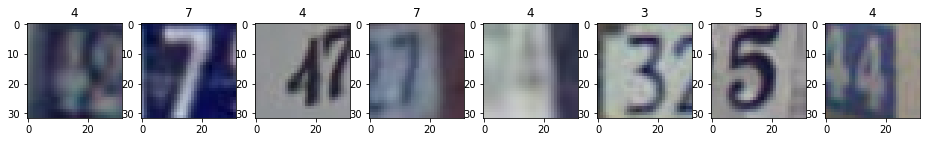

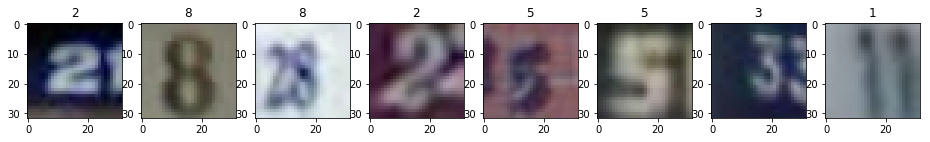

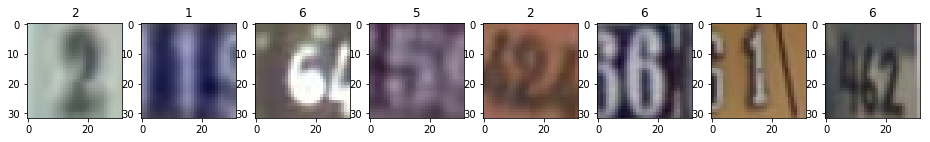

In [5]:
gallary_show(f_cls_train['X_cls'],f_cls_train['y_cls'],8)
gallary_show(f_cls_test['X_cls'],f_cls_test['y_cls'],8)
gallary_show(f_cls_extra['X_cls'],f_cls_extra['y_cls'],8)

#### 1.1.1.2. region proposal samples

*0 indicates not a digit, while 1 indicate a digit*

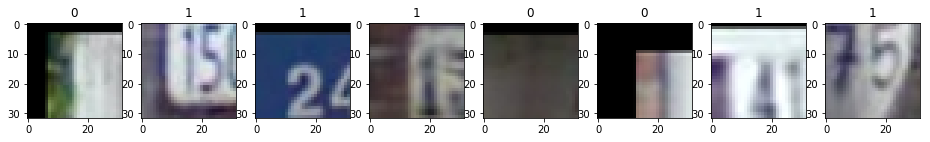

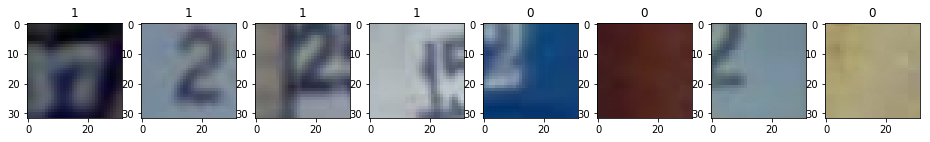

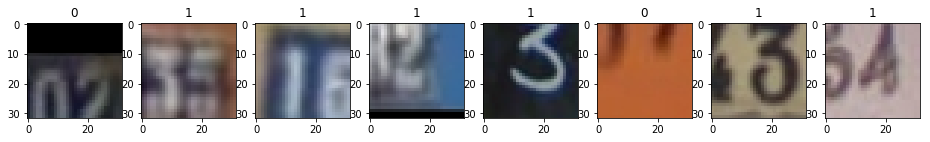

In [6]:
gallary_show(f_rp_train['X_rp'],f_rp_train['y_rp'],8)
gallary_show(f_rp_test['X_rp'],f_rp_test['y_rp'],8)
gallary_show(f_rp_extra['X_rp'],f_rp_extra['y_rp'],8)

#### 1.1.1.3. regression samples

*Titles are the shift of the center in the form of [dx,dy] in pixels*

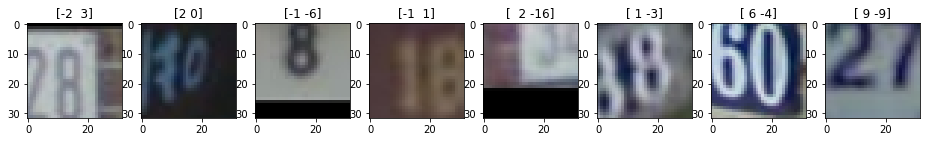

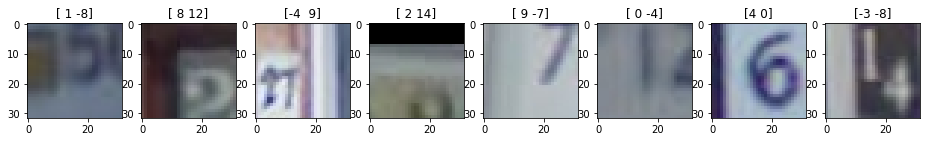

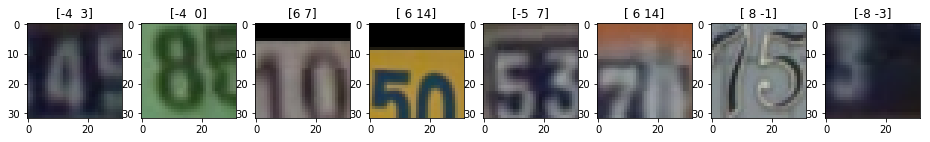

In [7]:
gallary_show(f_reg_train['X_reg'],f_reg_train['y_reg'],8)
gallary_show(f_reg_test['X_reg'],f_reg_test['y_reg'],8)
gallary_show(f_reg_extra['X_reg'],f_reg_extra['y_reg'],8)

### 1.1.2. Statistics

In [28]:
f_cls_train['y_cls'].shape

(73257, 1)

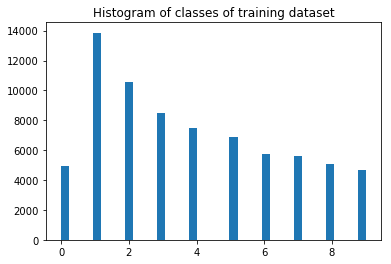

In [39]:
# Plot the histogram of classes
plt.hist(f_cls_train['y_cls'][:73257], bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram of classes of training dataset")
plt.show()

In [35]:
f_cls_extra['y_cls'].shape

(531131, 1)

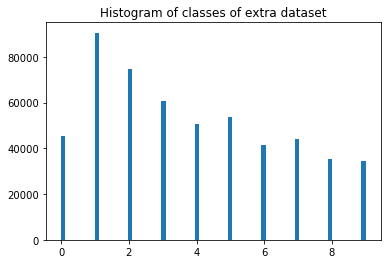

In [40]:
# Plot the histogram of classes
plt.hist(f_cls_extra['y_cls'][:531131], bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram of classes of extra dataset")
plt.show()

## 1.2. The classification network

### 1.2.1. Define the CNN model for classification in keras

In [3]:
# define the classification network
cls_single = Sequential()
cls_single.add(Convolution2D(32, 7, 7, input_shape=(32, 32, 3))) # out = (26,26,32)
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(64, 5, 5)) # out = (22,22,64)
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(128, 5, 5)) # out = (18,18,128)
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(256, 5, 5)) # out = (14,14,256)
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(512, 5, 5)) # out = (10,10,512)
cls_single.add(Dropout(0.5))
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(512, 10, 10)) # out = (1,1,1024)
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(512, 1, 1)) # out = (1,1,1024)
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(256, 1, 1)) # out = (1,1,512)
cls_single.add(Activation('relu'))
cls_single.add(Convolution2D(10, 1, 1)) # out = (1,1,10)
cls_single.add(Flatten())  # out = (10,)
cls_single.add(Activation('sigmoid'))  # out = (10,)

In [4]:
# save the archietecture of the model to an image
plot(cls_single, to_file='cls_single.png', show_shapes=True)

### 1.2.2. Train the model

In [5]:
# Compile the model
cls_single.compile('adam', 'categorical_crossentropy', ['accuracy'])
# Train the model
cls_single_history = cls_single.fit(np.transpose(np.float32(f_cls_train['X_cls'])/127.5-1.0,(0,3,2,1)), 
                                    label_binarize(f_cls_train['y_cls'], classes=np.arange(10)), 
                                    batch_size=1024, 
                                    nb_epoch=10, 
                                    validation_split=0.2)

Train on 58605 samples, validate on 14652 samples
Epoch 1/10
58605/58605 [==============================] - 68s - loss: 1.9493 - acc: 0.2842 - val_loss: 1.2162 - val_acc: 0.6008

In [6]:
# Plot the history of training
fig = plt.figure() #figsize=(8,6)
plt.plot(cls_single_history.history['acc'])
plt.plot(cls_single_history.history['val_acc'])
plt.title('classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('cls_single_train.png')
cls_single.save('cls_single_train.h5')

### 1.2.3. Extra training

In [7]:
# Train on the extra dataset
cls_single_history_extra = cls_single.fit(np.transpose(np.float32(f_cls_extra['X_cls'])/127.5-1.0,(0,3,2,1)), 
                                          label_binarize(f_cls_extra['y_cls'], classes=np.arange(10)), 
                                          batch_size=1024, 
                                          nb_epoch=5, 
                                          validation_split=0.1)

Train on 478017 samples, validate on 53114 samples
Epoch 1/5
478017/478017 [==============================] - 459s - loss: 0.1172 - acc: 0.9670 - val_loss: 0.0889 - val_acc: 0.9743

In [ ]:
fig = plt.figure() #figsize=(8,6)
plt.plot(cls_single_history_extra.history['acc'])
plt.plot(cls_single_history_extra.history['val_acc'])
plt.title('classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('cls_single_extra.png')
cls_single.save('cls_single_extra.h5')

### 1.2.4. Summary of the model

In [9]:
cls_single.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 26, 26, 32)    4736        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 26, 26, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 22, 22, 64)    51264       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 22, 22, 64)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## 1.3. The regression network

Load the trained CNN model for classification

In [3]:
cls_single = load_model('cls_single_extra.h5')

### 1.3.1. Define the CNN model for regression in keras

Define and train the CNN model for regression using transfer learning techniques

In [4]:
# define the classification network
reg_single = Sequential()
reg_single.add(Convolution2D(32, 7, 7, input_shape=(32, 32, 3), 
                             weights=[cls_single.get_weights()[0],cls_single.get_weights()[1]])) # out = (26,26,16)
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(64, 5, 5, 
                             weights=[cls_single.get_weights()[2],cls_single.get_weights()[3]])) # out = (22,22,64)
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(128, 5, 5, 
                             weights=[cls_single.get_weights()[4],cls_single.get_weights()[5]])) # out = (18,18,128)
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(256, 5, 5, 
                             weights=[cls_single.get_weights()[6],cls_single.get_weights()[7]])) # out = (14,14,256)
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(512, 5, 5, 
                             weights=[cls_single.get_weights()[8],cls_single.get_weights()[9]])) # out = (10,10,512)
reg_single.add(Dropout(0.5))
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(512, 10, 10)) # out = (1,1,512)
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(512, 1, 1)) # out = (1,1,512)
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(256, 1, 1)) # out = (1,1,256)
reg_single.add(Activation('relu'))
reg_single.add(Convolution2D(2, 1, 1)) # out = (1,1,2)
reg_single.add(Flatten())  # out = (10,)
reg_single.add(Activation('linear'))  # out = (10,)

In [5]:
plot(reg_single, to_file='reg_single.png', show_shapes=True)

In [6]:
reg_single.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 26, 26, 32)    4736        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 26, 26, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 22, 22, 64)    51264       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 22, 22, 64)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

### 1.3.2. Train the model

In [8]:
# Freeze feature extraction layers
for layer in reg_single.layers[0:9]:
    layer.trainable = False

In [9]:
# Compile the model
reg_single.compile('adam', 'mean_absolute_error', ['mean_absolute_error'])

In [10]:
# Train the model
reg_single_history = reg_single.fit(np.transpose(np.float32(f_reg_train['X_reg'])/127.5-1.0,(0,3,2,1)), 
                                    f_reg_train['y_reg'], 
                                    batch_size=1024, 
                                    nb_epoch=10, 
                                    validation_split=0.2)

Train on 58605 samples, validate on 14652 samples
Epoch 1/10
58605/58605 [==============================] - 19s - loss: 3.3025 - mean_absolute_error: 3.3025 - val_loss: 2.7863 - val_mean_absolute_error: 2.7863

In [11]:
# Plot the history of training
fig = plt.figure() #figsize=(8,6)
plt.plot(reg_single_history.history['mean_absolute_error'])
plt.plot(reg_single_history.history['val_mean_absolute_error'])
plt.title('regression accuracy')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('reg_single_train.png')
reg_single.save('reg_single_train.h5')

### 1.3.3. Extra training

In [13]:
# Train on the extra dataset
reg_single_history_extra = reg_single.fit(np.transpose(np.float32(f_reg_extra['X_reg'])/127.5-1.0,(0,3,2,1)), 
                                          f_reg_extra['y_reg'], 
                                          batch_size=1024, 
                                          nb_epoch=5, 
                                          validation_split=0.1)

Train on 478017 samples, validate on 53114 samples
Epoch 1/5
478017/478017 [==============================] - 110s - loss: 2.1393 - mean_absolute_error: 2.1393 - val_loss: 2.0060 - val_mean_absolute_error: 2.0060

In [14]:
# Plot the history of training
fig = plt.figure() #figsize=(8,6)
plt.plot(reg_single_history_extra.history['mean_absolute_error'])
plt.plot(reg_single_history_extra.history['val_mean_absolute_error'])
plt.title('regression accuracy')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('reg_single_extra.png')
reg_single.save('reg_single_extra.h5')

## 1.4. The region proposal network

Load the trained CNN model for regression

In [7]:
reg_single = load_model('reg_single_extra.h5')

### 1.4.1. Define the CNN model for region proposal in keras

Define and train the CNN model for region proposal using transfer learning techniques

In [15]:
# define the classification network
rp_single = Sequential()
rp_single.add(Convolution2D(32, 7, 7, input_shape=(32, 32, 3), 
                             weights=[cls_single.get_weights()[0],cls_single.get_weights()[1]])) # out = (26,26,16)
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(64, 5, 5, 
                             weights=[cls_single.get_weights()[2],cls_single.get_weights()[3]])) # out = (22,22,64)
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(128, 5, 5, 
                             weights=[cls_single.get_weights()[4],cls_single.get_weights()[5]])) # out = (18,18,128)
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(256, 5, 5, 
                             weights=[cls_single.get_weights()[6],cls_single.get_weights()[7]])) # out = (14,14,256)
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(512, 5, 5, 
                             weights=[cls_single.get_weights()[8],cls_single.get_weights()[9]])) # out = (10,10,512)
rp_single.add(Dropout(0.5))
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(512, 10, 10)) # out = (1,1,512)
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(512, 1, 1)) # out = (1,1,512)
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(256, 1, 1)) # out = (1,1,256)
rp_single.add(Activation('relu'))
rp_single.add(Convolution2D(2, 1, 1)) # out = (1,1,2)
rp_single.add(Flatten())  # out = (10,)
rp_single.add(Activation('sigmoid'))  # out = (10,)

In [16]:
plot(rp_single, to_file='rp_single.png', show_shapes=True)

In [17]:
rp_single.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 26, 26, 32)    4736        convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 26, 26, 32)    0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 22, 22, 64)    51264       activation_10[0][0]              
____________________________________________________________________________________________________
activation_11 (Activation)       (None, 22, 22, 64)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________

### 1.4.2. Train the model

In [18]:
for layer in rp_single.layers[0:9]:
    layer.trainable = False

In [19]:
# Compile the model
rp_single.compile('adam', 'categorical_crossentropy', ['accuracy'])
# Train the model
rp_single_history = rp_single.fit(np.transpose(np.float32(f_rp_train['X_rp'])/127.5-1.0,(0,3,2,1)), 
                                  label_binarize(f_rp_train['y_rp'], classes=np.arange(3))[:,:2], 
                                  batch_size=1024, 
                                  nb_epoch=10, 
                                  validation_split=0.2)

Train on 117211 samples, validate on 29303 samples
Epoch 1/10
117211/117211 [==============================] - 31s - loss: 0.2500 - acc: 0.8961 - val_loss: 0.2174 - val_acc: 0.9122

In [20]:
fig = plt.figure() #figsize=(8,6)
plt.plot(rp_single_history.history['acc'])
plt.plot(rp_single_history.history['val_acc'])
plt.title('classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('rp_single_train.png')
rp_single.save('rp_single_train.h5')

### 1.4.3. Extra training

In [21]:
# Train the model
rp_single_history_extra = rp_single.fit(np.transpose(np.float32(f_rp_extra['X_rp'])/127.5-1.0,(0,3,2,1)), 
                                  label_binarize(f_rp_extra['y_rp'], classes=np.arange(3))[:,:2], 
                                  batch_size=1024, 
                                  nb_epoch=5, 
                                  validation_split=0.1)

Train on 956035 samples, validate on 106227 samples
Epoch 1/5
956035/956035 [==============================] - 217s - loss: 0.1987 - acc: 0.9207 - val_loss: 0.1873 - val_acc: 0.9253

In [22]:
fig = plt.figure() #figsize=(8,6)
plt.plot(rp_single_history_extra.history['acc'])
plt.plot(rp_single_history_extra.history['val_acc'])
plt.title('classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.savefig('rp_single_extra.png')
rp_single.save('rp_single_extra.h5')

## 1.5. Model combination

Build a model which can be applied to the whole image

In [3]:
cls_single = load_model('cls_single_extra.h5')
reg_single = load_model('reg_single_extra.h5')
rp_single = load_model('rp_single_extra.h5')

### 1.5.1. Shared layers

In [23]:
# This part is shared by all nets
inputs = Input(shape=(96, 192, 3))
x = Convolution2D(32, 7, 7, weights=[cls_single.get_weights()[0],cls_single.get_weights()[1]])(inputs) # out = (26,26,32)
x = Activation('relu')(x)
x = Convolution2D(64, 5, 5, weights=[cls_single.get_weights()[2],cls_single.get_weights()[3]])(x) # out = (22,22,64)
x = Activation('relu')(x)
x = Convolution2D(128, 5, 5, weights=[cls_single.get_weights()[4],cls_single.get_weights()[5]])(x) # out = (18,18,128)
x = Activation('relu')(x)
x = Convolution2D(256, 5, 5, weights=[cls_single.get_weights()[6],cls_single.get_weights()[7]])(x) # out = (14,14,256)
x = Activation('relu')(x)
x = Convolution2D(512, 5, 5, weights=[cls_single.get_weights()[8],cls_single.get_weights()[9]])(x) # out = (10,10,512)
feature_map = Activation('relu')(x)

### 1.5.2. The classification net

In [24]:
# The classification net
y_cls = Convolution2D(512, 10, 10, weights=[cls_single.get_weights()[10],cls_single.get_weights()[11]])(feature_map) # out = (1,1,1024)
y_cls = Activation('relu')(y_cls)
y_cls = Convolution2D(512, 1, 1, weights=[cls_single.get_weights()[12],cls_single.get_weights()[13]])(y_cls) # out = (1,1,1024)
y_cls = Activation('relu')(y_cls)
y_cls = Convolution2D(256, 1, 1, weights=[cls_single.get_weights()[14],cls_single.get_weights()[15]])(y_cls) # out = (1,1,512)
y_cls = Activation('relu')(y_cls)
y_cls = Convolution2D(10, 1, 1, weights=[cls_single.get_weights()[16],cls_single.get_weights()[17]])(y_cls) # out = (1,1,10)
cls_map = Activation('sigmoid')(y_cls)  # out = (10,)

### 1.5.3. The regression net

In [25]:
# The regression net
y_reg = Convolution2D(512, 10, 10, weights=[reg_single.get_weights()[10],reg_single.get_weights()[11]])(feature_map) # out = (1,1,1024)
y_reg = Activation('relu')(y_reg)
y_reg = Convolution2D(512, 1, 1, weights=[reg_single.get_weights()[12],reg_single.get_weights()[13]])(y_reg) # out = (1,1,1024)
y_reg = Activation('relu')(y_reg)
y_reg = Convolution2D(256, 1, 1, weights=[reg_single.get_weights()[14],reg_single.get_weights()[15]])(y_reg) # out = (1,1,512)
y_reg = Activation('relu')(y_reg)
y_reg = Convolution2D(2, 1, 1, weights=[reg_single.get_weights()[16],reg_single.get_weights()[17]])(y_reg) # out = (1,1,2)
reg_map = Activation('linear')(y_reg)  # out = (2,)

### 1.5.4. The region proposal net

In [26]:
# the region proposal net
y_rp = Convolution2D(512, 10, 10, weights=[rp_single.get_weights()[10],rp_single.get_weights()[11]])(feature_map) # out = (1,1,1024)
y_rp = Activation('relu')(y_rp)
y_rp = Convolution2D(512, 1, 1, weights=[rp_single.get_weights()[12],rp_single.get_weights()[13]])(y_rp) # out = (1,1,1024)
y_rp = Activation('relu')(y_rp)
y_rp = Convolution2D(256, 1, 1, weights=[rp_single.get_weights()[14],rp_single.get_weights()[15]])(y_rp) # out = (1,1,512)
y_rp = Activation('relu')(y_rp)
y_rp = Convolution2D(2, 1, 1, weights=[rp_single.get_weights()[16],rp_single.get_weights()[17]])(y_rp) # out = (1,1,10)
rp_map = Activation('sigmoid')(y_rp)  # out = (2,)

### 1.5.5. Combination

In [27]:
all_in_one_model = Model(input=inputs, output=[cls_map, reg_map, rp_map])

In [28]:
all_in_one_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 96, 192, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_19 (Convolution2D) (None, 90, 186, 32)   4736        input_1[0][0]                    
____________________________________________________________________________________________________
activation_19 (Activation)       (None, 90, 186, 32)   0           convolution2d_19[0][0]           
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 86, 182, 64)   51264       activation_19[0][0]              
___________________________________________________________________________________________

### 1.5.6. Check consistency

In [29]:
all_in_one_model.built

True

In [30]:
plot(all_in_one_model, to_file='all_in_one_model.png', show_shapes=True)
all_in_one_model.save('all_in_one_model.h5')

In [31]:
test_image = np.ones([96,192,3])

In [32]:
np.expand_dims(test_image, axis=0).shape

(1, 96, 192, 3)

In [33]:
test_result = all_in_one_model.predict(np.expand_dims(test_image, axis=0))

In [34]:
test_result[2].shape

(1, 65, 161, 2)

## 1.6. Evaluation

### 1.6.1. classification predictions

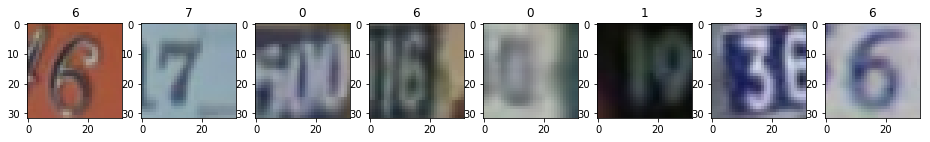

In [19]:
gallary_show(f_cls_test['X_cls'],
             np.argmax(cls_single.predict(np.transpose(np.float32(f_cls_test['X_cls'])/127.5-1.0,(0,3,2,1))),axis=1),8)

### 1.6.2. region proposal predictions

In [20]:
rp_test_prediction = np.argmax(rp_single.predict(np.transpose(np.float32(f_rp_test['X_rp'])/127.5-1.0,(0,3,2,1))),axis=1)

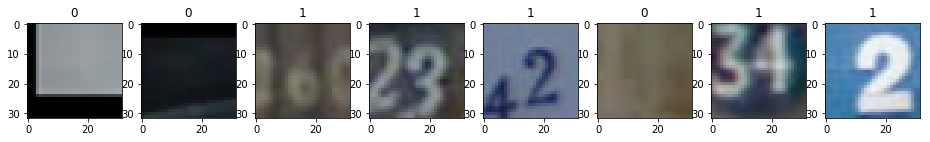

In [21]:
gallary_show(f_rp_test['X_rp'],rp_test_prediction,8)

### 1.6.3. regression predictions

In [22]:
reg_test_prediction = np.int32(reg_single.predict(np.transpose(np.float32(f_reg_test['X_reg'])/127.5-1.0,(0,3,2,1))))

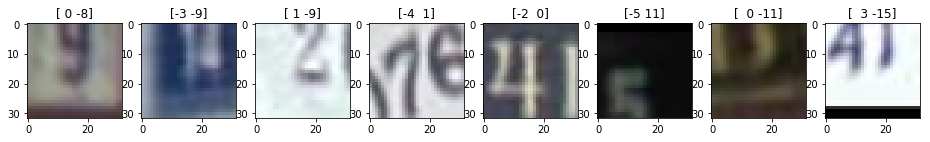

In [23]:
gallary_show(f_reg_test['X_reg'],reg_test_prediction,8)

### 1.6.4. classification accuracy

In [26]:
cls_single.evaluate(np.transpose(np.float32(f_cls_test['X_cls'])/127.5-1.0,(0,3,2,1)), 
                    label_binarize(f_cls_test['y_cls'], classes=np.arange(10)))

26016/26032 [============================>.] - ETA: 0s 

[0.2006052443178081, 0.95159803318992009]

### 1.6.5. region proposal accuracy

In [27]:
rp_single.evaluate(np.transpose(np.float32(f_rp_test['X_rp'])/127.5-1.0,(0,3,2,1)), 
                    label_binarize(f_rp_test['y_rp'], classes=np.arange(3))[:,:2])

52064/52064 [==============================] - 45s      

[0.19947120867046791, 0.92117393976644135]

### 1.6.6. regression accuracy

In [28]:
reg_single.evaluate(np.transpose(np.float32(f_reg_test['X_reg'])/127.5-1.0,(0,3,2,1)), f_reg_test['y_reg'])

26016/26032 [============================>.] - ETA: 0s 

[2.5318032171217739, 2.5318032146306146]